In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib
import pyart
import glob
import sys
import yaml
sys.path.append('../')
from core import basis_set, get_recording_units
from plotting import *
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
conditions = ['C','CB','GB','GM','N']
method = 'pls'
win=100
nbasis=15
comparisons = [
    ('GB','CB'),('GB', 'GM'),('GM','CB')
]

with open('../../inputs/units/excluded_units.txt', 'r') as file:
    bad = file.read().split('\n')
with open('../../inputs/units/drifted_units.txt', 'r') as file:
    drifted = file.read().split('\n')
excluded = bad + drifted

In [9]:
scores = []

for exp in ['nat8b', 'synth8b']:

    with open(f'../../inputs/units/rho/{exp}.yml') as rhofile:
        exp_cfg = yaml.safe_load(rhofile)
    spectrograms = pd.read_csv(f'/scratch/bple/induction/{exp}/spectrograms.csv', index_col=['stimulus', 'time'])
    spectrograms.sort_index(inplace=True)
    stim_info = pd.read_csv(f'../../inputs/stimuli_lists/{exp}_info.csv', index_col='stimulus')    
    motifs = stim_info.motif.unique()
    gaplocs = [1,2] if exp=='nat8b' else [2,4]
    gtype = '' if exp=='nat8b' else 'a'
    for cfg in exp_cfg:
        dataset = cfg['dataset']
        if dataset!='naive': # comment out for OPERANT
            continue
        for sub, subinfo in cfg['subjects'].items():
            responses = pd.read_hdf(f"/scratch/bple/induction/{exp}/" \
                                    f"{dataset}/{sub}_delemb_win{win}_basis{nbasis}.h5",\
                                    key='Induction', mode="r")
            for region_data in subinfo:
                for region, recordings in region_data.items():
                    for recording in recordings:
                        rec_units = get_recording_units(recording, excluded)
                        model_file = f"/scratch/bple/induction/models/{exp}/rho/"\
                                     f"{region}_{recording}_{method}_model_win{win}_basis{nbasis}.pkl"
                        models = joblib.load(model_file)
                        rec_resp = responses[rec_units].copy()
                        _, cscores = get_scores(
                            exp, models, spectrograms, rec_resp, motifs, gtype,
                            conditions, comparisons, full=False
                        )
                        cscores['exp'] = exp
                        cscores['subject'] = sub
                        cscores['region'] = region
                        cscores['recording'] = recording
                        cscores = cscores.drop('ndim', axis=1)
                        scores.append(cscores.copy())

33 Units found for recording C43_1_1
Exp nat8b best # of components is 5
36 Units found for recording C43_3_2
Exp nat8b best # of components is 3
14 Units found for recording C43_4_1
Exp nat8b best # of components is 14
7 Units found for recording C43_5_2
Exp nat8b best # of components is 6
75 Units found for recording C54a_4_2
Exp nat8b best # of components is 5
31 Units found for recording C54a_4_3
Exp nat8b best # of components is 5
48 Units found for recording C54a_1_1
Exp nat8b best # of components is 12
74 Units found for recording C54a_2_2
Exp nat8b best # of components is 6
9 Units found for recording Rb279_3_1
Exp nat8b best # of components is 2
3 Units found for recording Rb279_1_1
Exp nat8b best # of components is 40
36 Units found for recording C43_3_1
Exp synth8b best # of components is 8
28 Units found for recording C43_4_2
Exp synth8b best # of components is 6
10 Units found for recording C43_5_1
Exp synth8b best # of components is 6
40 Units found for recording C54a_4_1

In [10]:
results = pd.concat(scores).set_index(['exp','region','subject','recording', 'comp', 'motif', 'gap']).sort_index()
test = results.unstack('comp').droplevel(0, axis=1)

In [15]:
test['S'] = 0.25 *\
    np.sqrt(test['GBCB']+test['GBGM']+test['GMCB']) *\
    np.sqrt(-test['GBCB']+test['GBGM']+test['GMCB']) *\
    np.sqrt(test['GBCB']-test['GBGM']+test['GMCB']) *\
    np.sqrt(test['GBCB']+test['GBGM']-test['GMCB'])         
test['d'] = test['S']*2/test['GMCB']

testdt = test.groupby(['exp','region', 'subject', 'recording']).apply(
    lambda df: 
    (-df['GBCB']+df['GBGM']) / np.abs(-df['GBCB']+df['GBGM']) *
    np.sqrt(np.abs(-df['GBCB']+df['GBGM']) / df['d'])
).to_frame('RI').droplevel([3,4,5], axis=0)
testdt.head()
# testdt.to_csv('./stats/RI-rho.csv')

In [16]:
sns.set_style('whitegrid')

plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['xtick.minor.size'] = 7
plt.rcParams['xtick.minor.width'] = 2

plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 4
plt.rcParams['ytick.minor.size'] = 7
plt.rcParams['ytick.minor.width'] = 2

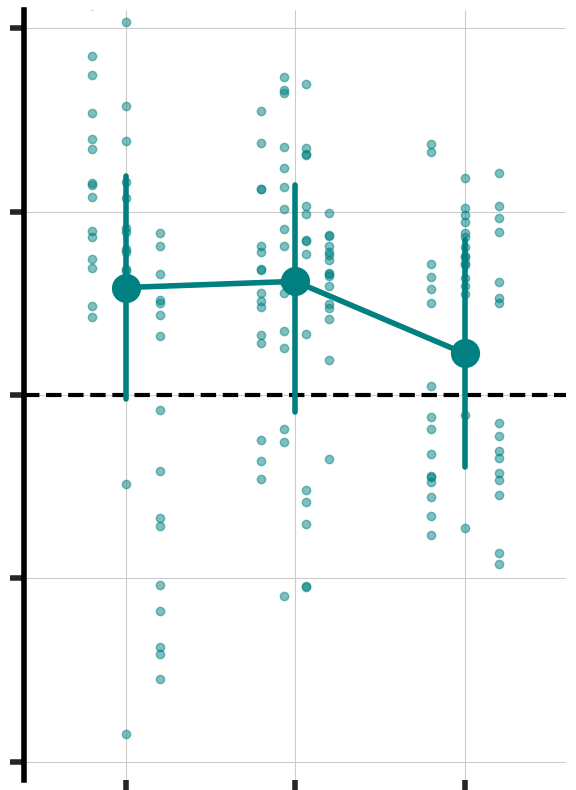

In [53]:
colrs = ['teal', 'maroon']

ax = plt.figure(figsize=(7,10)).add_subplot()

for irg, region in enumerate(['NCM', 'L2', 'CM']):
    dt = testdt.loc['nat8b'].loc[region]
    nrec = len(dt.index.get_level_values('recording').unique())
    space = np.linspace(-0.2, 0.2, nrec)
    for irc, (rec, recdata) in enumerate(dt.groupby('recording')):
        ax.plot(
            np.repeat(irg+space[irc], 16), recdata,
            color=colrs[0],ls='',marker='o', alpha=0.5
        )
ax.axhline(0, ls='--', lw=3, color='black')
ax.plot(
    [0,0], [-0.0216, 1.194],
    color=colrs[0], lw=4
)
ax.plot(
    [1,1], [-0.092, 1.148],
    color=colrs[0], lw=4
)
ax.plot(
    [2,2], [-0.3954, 0.848],
    color=colrs[0], lw=4
)

ax.plot(
    [0,1,2], [0.5862, 0.6199, 0.2264],
    color=colrs[0], lw=4, marker='o', markersize=20, markerfacecolor=colrs[0]
)

ax.set_ylim(-2.1,2.1)
ax.set_xlim(-0.6, 2.6)
ax.set_yticks([-2,-1,0,1,2], [])
ax.set_xticks([0,1,2], [])
plt.setp(ax.spines.values(), lw=4, color='black')
sns.despine(ax=ax, top=True, bottom=True, right=True)

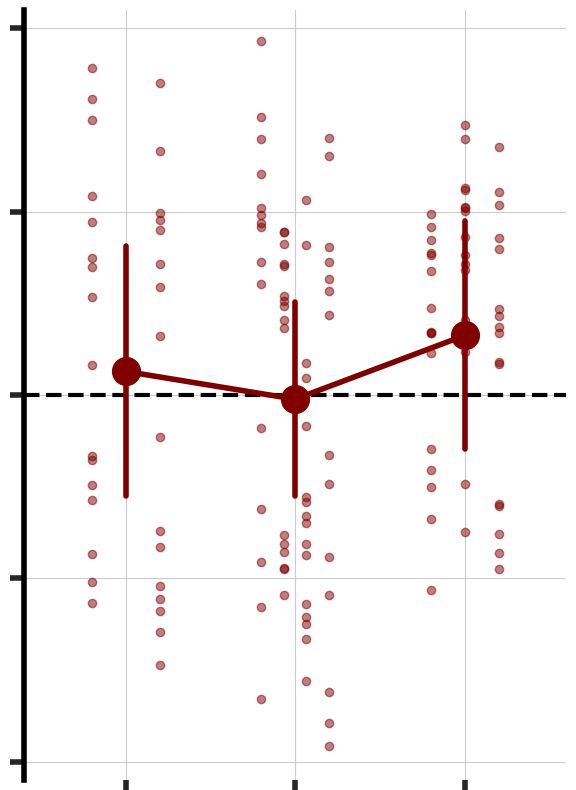

In [54]:
ax = plt.figure(figsize=(7,10)).add_subplot()

for irg, region in enumerate(['NCM', 'L2', 'CM']):
    dt = testdt.loc['synth8b'].loc[region]
    nrec = len(dt.index.get_level_values('recording').unique())
    space = np.linspace(-0.2, 0.2, nrec)
    for irc, (rec, recdata) in enumerate(dt.groupby('recording')):
        ax.plot(
            np.repeat(irg+space[irc], 16), recdata,
            color=colrs[1],ls='',marker='o', alpha=0.5
        )
        
ax.axhline(0, ls='--', lw=3, color='black')
ax.plot(
    [0,0], [-0.5535, 0.811],
    color=colrs[1], lw=4
)
ax.plot(
    [1,1], [-0.5508, 0.505],
    color=colrs[1], lw=4
)
ax.plot(
    [2,2], [-0.2971, 0.947],
    color=colrs[1], lw=4
)

ax.plot(
    [0,1,2], [0.1288, -0.0229, 0.3248],
    color=colrs[1], lw=4, marker='o', markersize=20, markerfacecolor=colrs[1]
)

ax.set_ylim(-2.1,2.1)
ax.set_xlim(-0.6, 2.6)
ax.set_yticks([-2,-1,0,1,2], [])
ax.set_xticks([0,1,2], [])
plt.setp(ax.spines.values(), lw=4, color='black')
sns.despine(ax=ax, top=True, bottom=True, right=True)